# Import Modules

In [1]:
import pandas as pd 
import numpy as np 
import librosa
import glob
from ast import literal_eval

import torch
import torch.nn as nn
import os
import random
from matplotlib import pyplot as plt 
import seaborn as sns

from warnings import filterwarnings 
filterwarnings("ignore")

# Config

In [2]:
class Config:
    train_dir = "/kaggle/input/birdclef-2025/train_audio"
    seed = 42
    train_csv = "/kaggle/input/birdclef-2025/train.csv"
    sample_csv = "/kaggle/input/birdclef-2025/sample_submission.csv"
    test_soundscapes = "/kaggle/input/birdclef-2025/test_soundscapes"
    
    sr = int(32e3)
    num_classes = 206
    n_fft = 1024
    hop_length = 500

    n_mels = 128
    fmin = 50
    fmax = 16000
    power = 2

# Helper function

In [3]:
def set_seed(seed: int = Config.seed) -> None:
    random.seed(seed) 
    np.random.seed(seed) 
    torch.manual_seed(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed) 
        torch.cuda.manual_seed_all(seed)
        
    torch.backends.cudnn.determinstic = True 
    torch.backends.cudnn.benchmark = False
    
    print(f" [INFO] Set Seed: {seed}")
    
set_seed()

 [INFO] Set Seed: 42


# Loading Dataset

In [4]:
data_df = pd.read_csv(Config.train_csv)

for col in ('secondary_labels', 'type'):
    data_df[col] = data_df[col].apply(lambda x: "###".join(literal_eval(x)))
    
data_df['filename'] = data_df['filename'].apply(lambda x: Config.train_dir + "/" + x) 
data_df.sample(10)

,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,common_name,author,license
27685,yeofly1,,call,/kaggle/input/birdclef-2025/train_audio/yeofly...,XC,4.0,https://xeno-canto.org/250351,-4.4010,-79.8540,Tolmomyias sulphurescens,Yellow-olive Flycatcher,Niels Krabbe,cc-by-sa 4.0
25019,whbman1,,mechanical sounds,/kaggle/input/birdclef-2025/train_audio/whbman...,XC,5.0,https://xeno-canto.org/268585,-19.7323,-41.8141,Manacus manacus,White-bearded Manakin,Fabrice Schmitt,cc-by-nc-sa 4.0
96,21211,,,/kaggle/input/birdclef-2025/train_audio/21211/...,XC,3.0,https://xeno-canto.org/913998,4.0946,-52.6862,Allobates femoralis,Spotted-thighed Poison Frog,Delaitre guillaume,cc-by-nc-sa 4.0
5771,bugtan,,flight call,/kaggle/input/birdclef-2025/train_audio/bugtan...,XC,5.0,https://xeno-canto.org/480423,-0.4383,-76.2791,Thraupis episcopus,Blue-gray Tanager,Jerome Fischer,cc-by-nc-sa 4.0
21879,strher,greani1###grekis,flight call,/kaggle/input/birdclef-2025/train_audio/strher...,XC,3.5,https://xeno-canto.org/287867,-22.4508,-42.7735,Butorides striata,Striated Heron,Jerome Fischer,cc-by-nc-sa 4.0
550,517119,,,/kaggle/input/birdclef-2025/train_audio/517119...,iNat,0.0,https://static.inaturalist.org/sounds/627646.mp3,13.9296,-88.1021,Rhinella horribilis,Giant Toad,Carlos Funes,cc-by 4.0
1512,anhing,,,/kaggle/input/birdclef-2025/train_audio/anhing...,iNat,0.0,https://static.inaturalist.org/sounds/198504.wav,24.7054,-81.3802,Anhinga anhinga,Anhinga,Nick Tepper,cc-by-nc 4.0
18405,smbani,,call,/kaggle/input/birdclef-2025/train_audio/smbani...,XC,3.0,https://xeno-canto.org/461360,-12.7210,-71.3649,Crotophaga ani,Smooth-billed Ani,Blair Jollands,cc-by-nc-sa 4.0
19569,socfly1,,,/kaggle/input/birdclef-2025/train_audio/socfly...,iNat,0.0,https://static.inaturalist.org/sounds/360705.wav,20.5138,-97.4619,Myiozetetes similis,Social Flycatcher,pozaricaalnatural,cc-by-nc 4.0
11127,grekis,,,/kaggle/input/birdclef-2025/train_audio/grekis...,iNat,0.0,https://static.inaturalist.org/sounds/356146.wav,27.5389,-99.4917,Pitangus sulphuratus,Great Kiskadee,Diane Bricmont,cc-by-nc 4.0


In [5]:
# Null Check
data_df.isnull().sum()

primary_label         0
secondary_labels      0
type                  0
filename              0
collection            0
rating                0
url                   0
latitude            809
longitude           809
scientific_name       0
common_name           0
author                0
license               0
dtype: int64

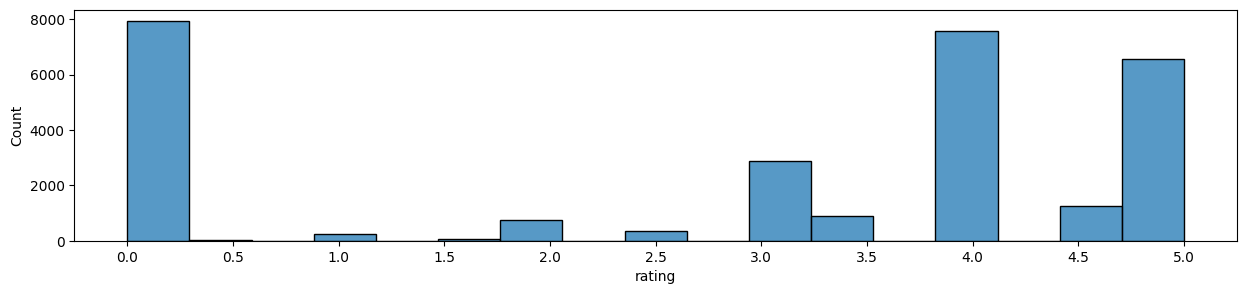

In [6]:
# Distribution of the ratings 
plt.figure(figsize = (15, 3))
sns.histplot(data_df, x = 'rating') 
plt.xticks(np.arange(0, 5.5, 0.5))
plt.show();

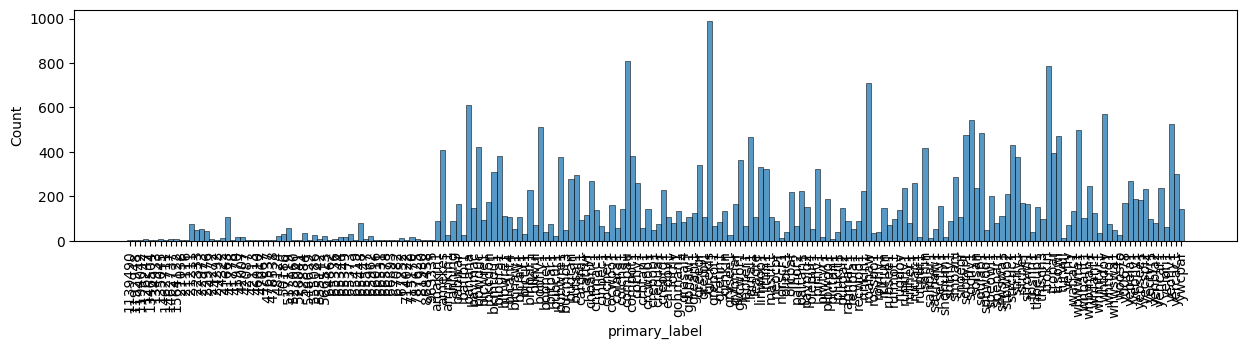

In [7]:
# Distribution of the primary label 
plt.figure(figsize = (15, 3)) 
sns.histplot(data_df, x = 'primary_label')
plt.xticks(rotation = 90)
plt.show();

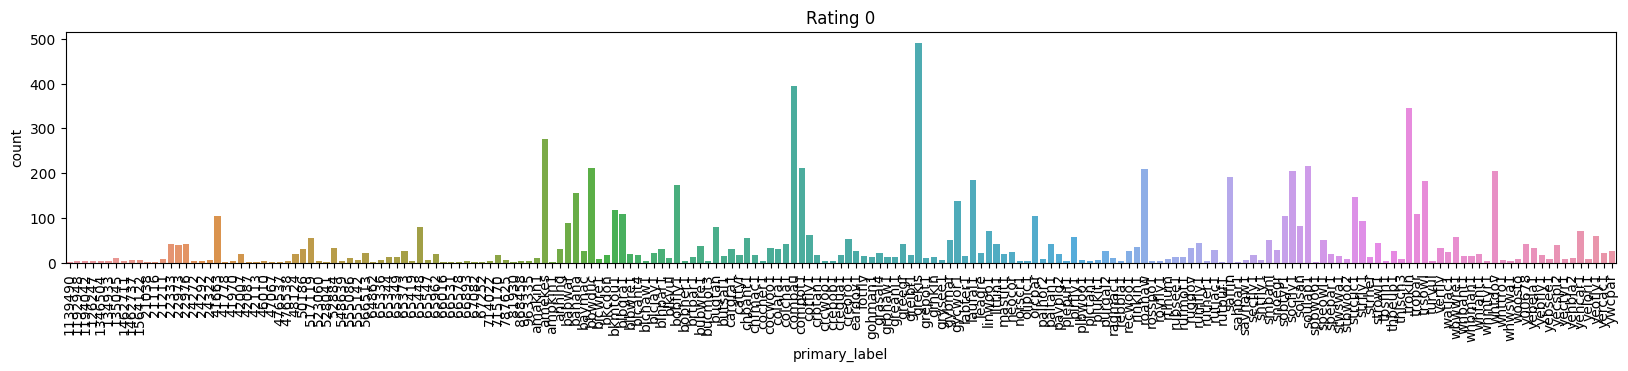

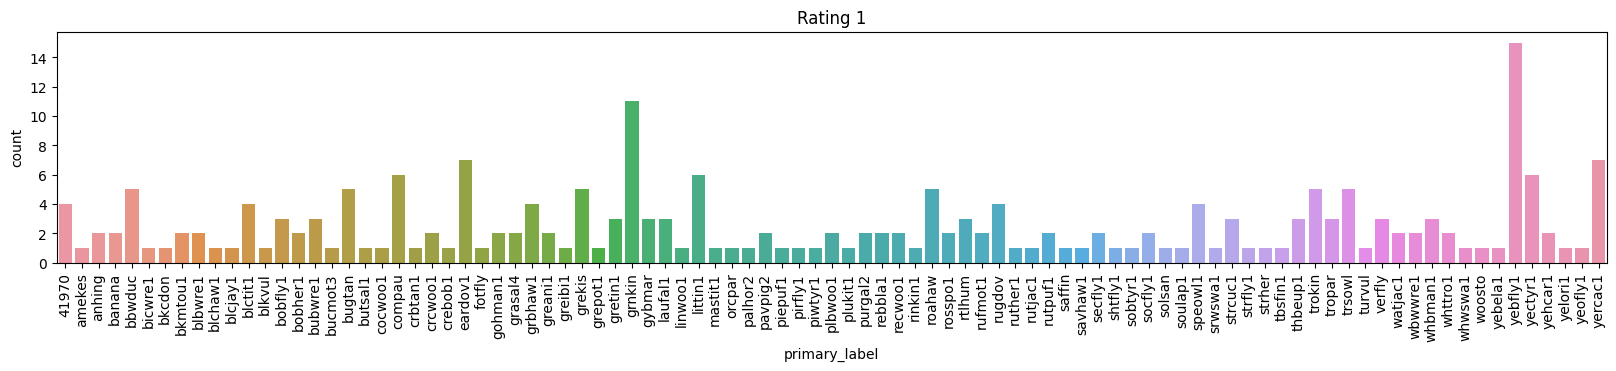

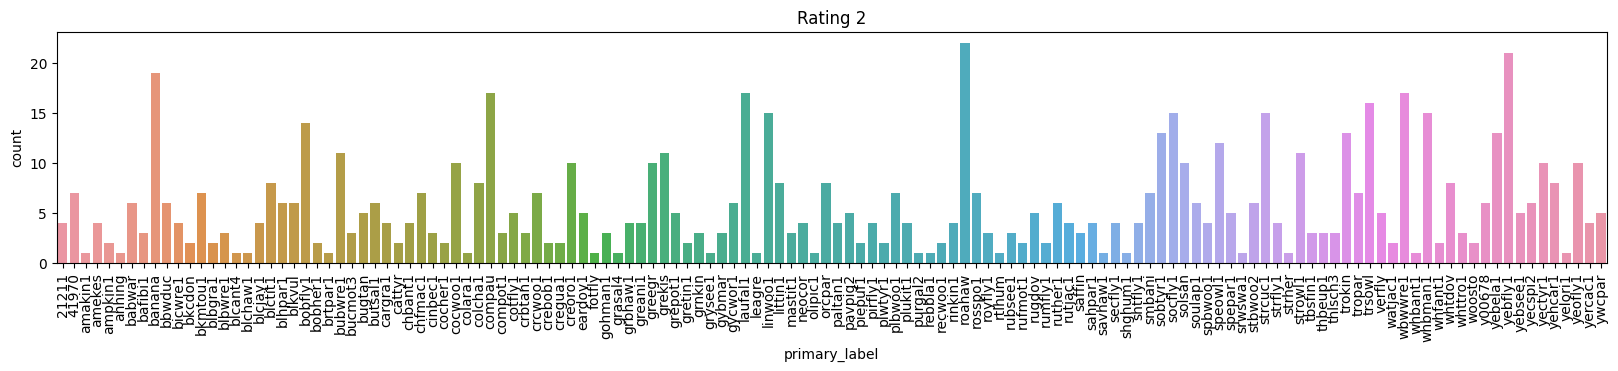

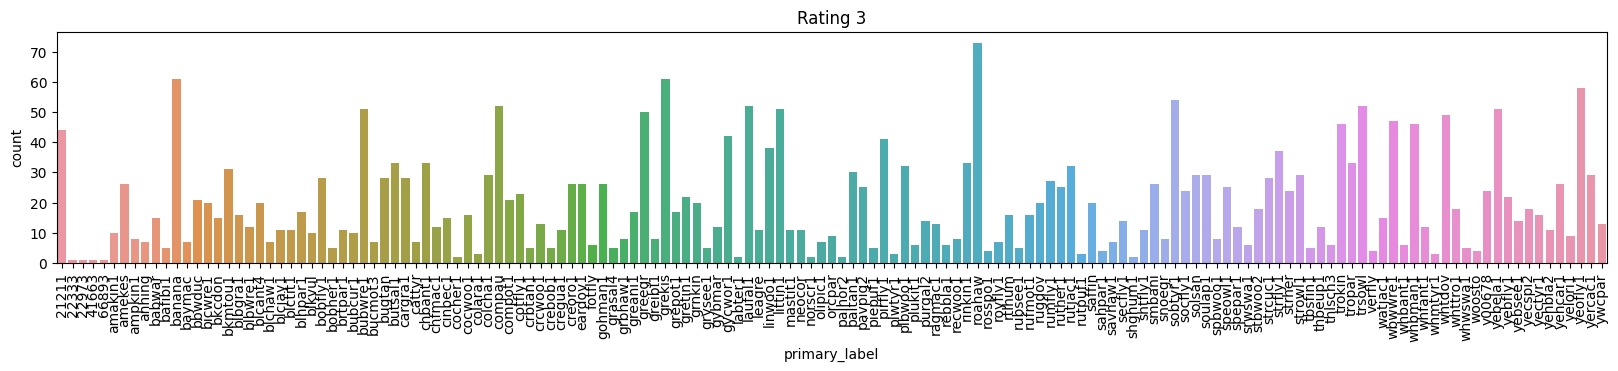

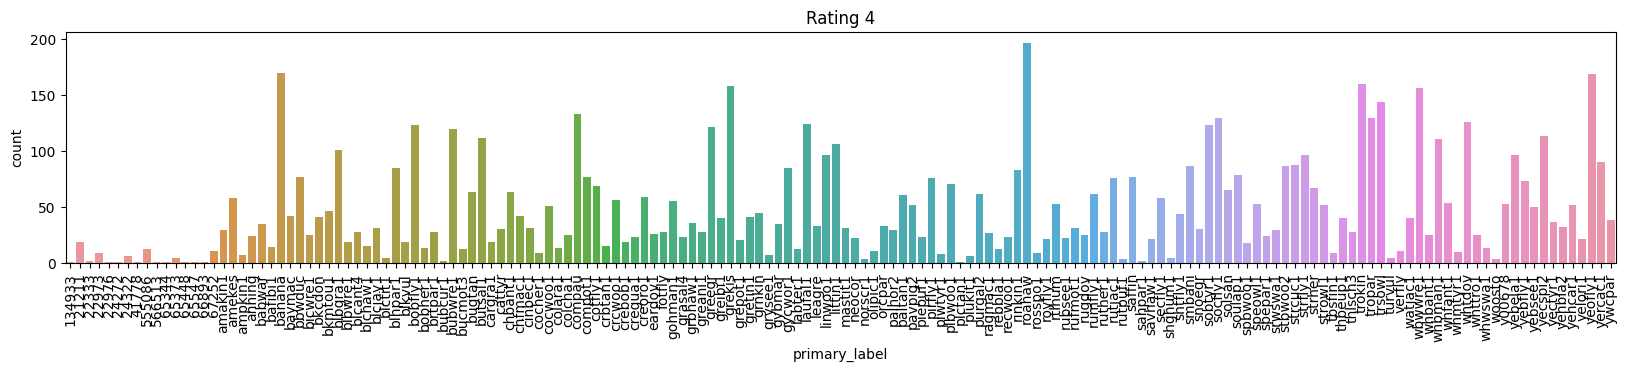

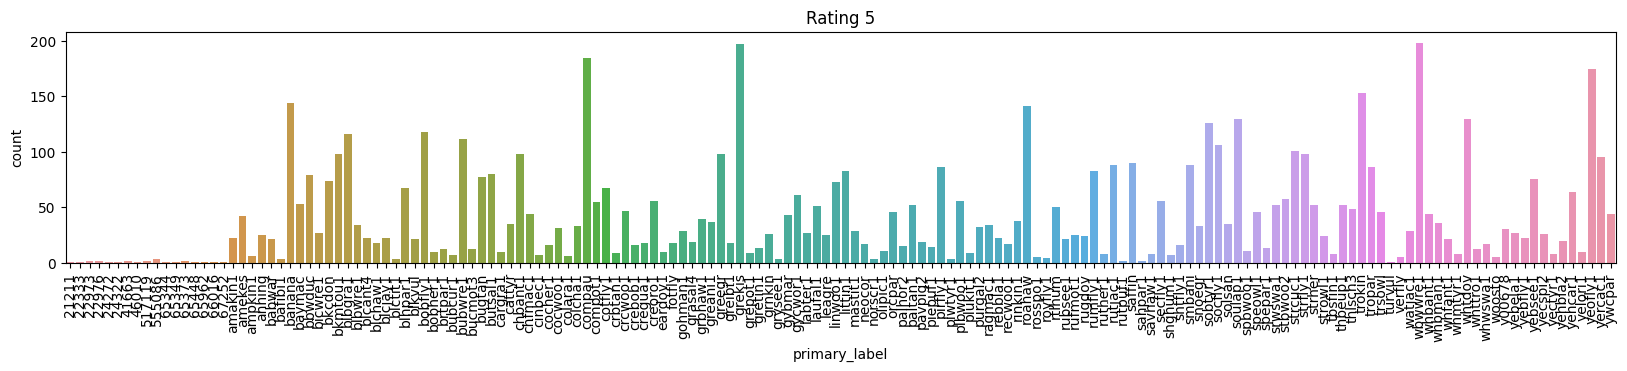

In [8]:
# Distribution of the primary label with different ratings
for r in range(0, 6):
    plt.figure(figsize = (20, 3))
    sns.countplot(data_df [data_df['rating'] == float(r)], x = 'primary_label')
    plt.title(f"Rating {r}")
    plt.xticks(rotation = 90)
    plt.show();

In [9]:
# Statistics of audio durations
durations = []
for idx, row in data_df.sample(100).iterrows():
    data, _ = librosa.load(row['filename'], sr = Config.sr) 
    durations.append(librosa.get_duration(y = data, sr = Config.sr))

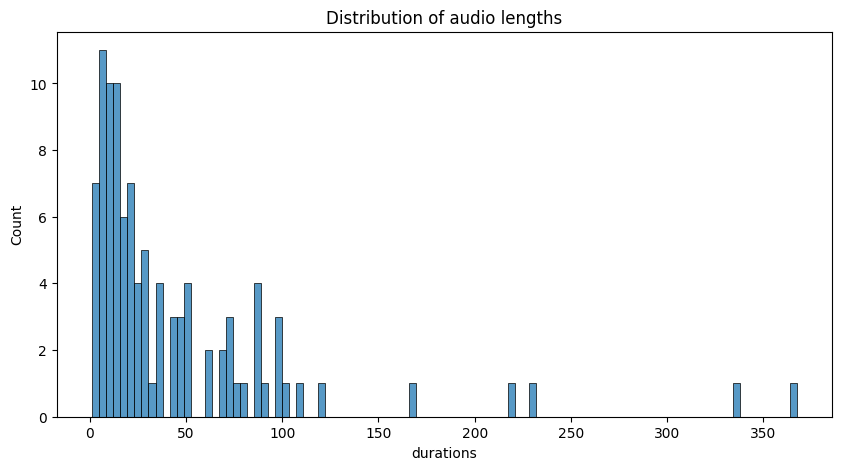

,durations
count,100.000000
mean,45.138718
std,60.691741
min,1.253875
25%,11.122898
50%,22.838453
75%,54.015906
max,367.296000


In [10]:
d_df = pd.DataFrame(columns = ["durations"], data = durations)

plt.figure(figsize = (10, 5))
plt.title("Distribution of audio lengths")
sns.histplot(d_df, x = "durations", bins = 100) 
plt.show();

d_df.describe()

# Check out spectrograms

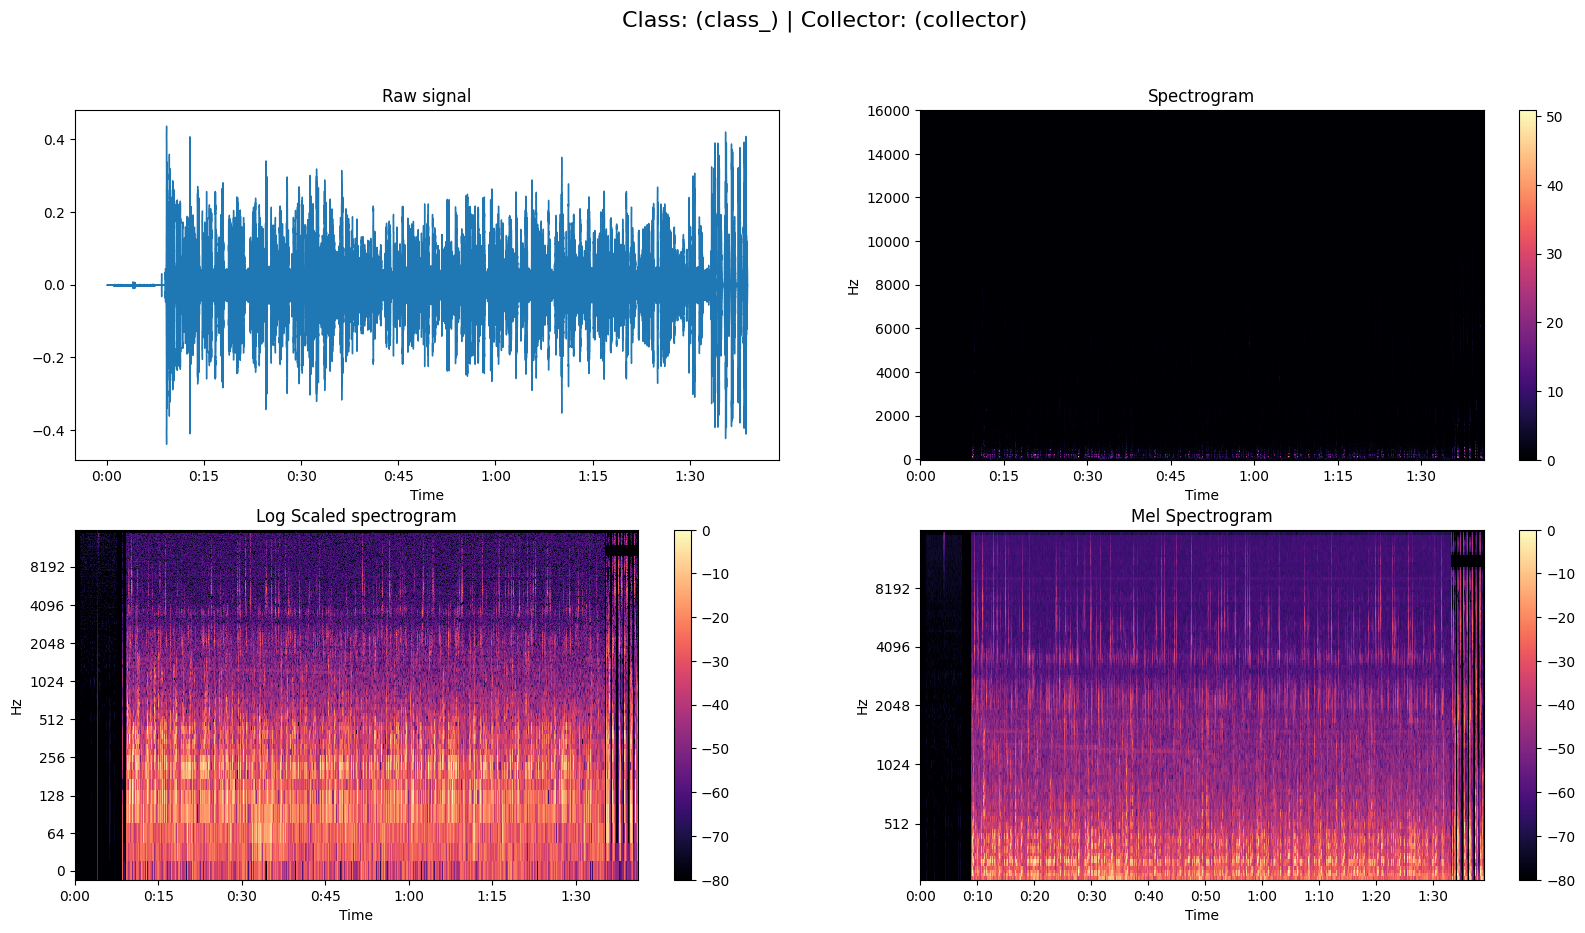

In [11]:
def show_signal(file_path):
    class_, collector = file_path.split("/")[-2:]
    
    y, sr = librosa.load(file_path, sr = Config.sr)\
    
    fig, axes = plt.subplots(2, 2, figsize = (20, 10))
    
    fig.suptitle(f"Class: (class_) | Collector: (collector)", fontsize = 16)
    
    # Plotting raw signal I
    librosa.display.waveshow(y, sr = sr, ax = axes[0, 0]) 
    axes [0, 0].set_title("Raw signal")
    

    # Plotting fourier transformed signal
    ft = np.abs(librosa.stft(
        y,
        n_fft = Config.n_fft,
        hop_length = Config.hop_length 
    ))
    im1 = librosa.display.specshow(
        ft,
        sr = sr,
        x_axis = 'time',
        y_axis = 'linear',
        ax = axes[0, 1]
    )
    fig.colorbar(im1, ax = axes[0, 1])
    axes[0, 1].set_title("Spectrogram")

    
    # Plotting log scaled fourier transformed signal 
    ft_db = librosa.amplitude_to_db(ft, ref= np.max) 
    im2 = librosa.display.specshow(
        ft_db,
        sr = sr,
        x_axis = 'time',
        y_axis = 'log',
        ax = axes[1, 0]
    )
    fig.colorbar (im2, ax = axes [1, 0])
    axes[1, 0].set_title("Log Scaled spectrogram")

    
    # Plotting mel spectrograms
    mel_sp = librosa.feature.melspectrogram(
        y = y,
        sr = Config.sr,
        fmin = Config.fmin,
        fmax = Config.fmax,
        power = Config.power,
        n_mels = Config.n_mels,
    )
    mel_sp= librosa.power_to_db(mel_sp, ref = np.max) 
    im3 = librosa.display.specshow(
        mel_sp,
        y_axis = 'mel', 
        sr = Config.sr, 
        fmin = Config.fmin, 
        x_axis = 'time',
        fmax = Config.fmax,
        ax = axes[1, 1]
    )
    fig.colorbar (im3, ax = axes[1, 1])
    axes[1, 1].set_title("Mel Spectrogram")

    
    plt.show();

show_signal(data_df['filename'].values[0])